# Cab Fare Prediction


#### Problem Statement​ -
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected thehistorical data from your pilot project and now have a requirement to apply analytics forfare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

In [197]:
# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# set the working directory
os.chdir('C:/Users/admin/Documents/Python Files')
os.getcwd()

'C:\\Users\\admin\\Documents\\Python Files'

The details of data attributes in the dataset are as follows:
-  pickup_datetime - timestamp value indicating when the cab ride started.
-  pickup_longitude - float for longitude coordinate of where the cab ride started.
-  pickup_latitude - float for latitude coordinate of where the cab ride started.
-  dropoff_longitude - float for longitude coordinate of where the cab ride ended.
-  dropoff_latitude - float for latitude coordinate of where the cab ride ended.
-  passenger_count - an integer indicating the number of passengers in the cab ride.

predictive modeling machine learning project can be broken down into below workflow: 
1. Prepare Problem 
a) Load libraries b) Load dataset 
2. Summarize Data a) Descriptive statistics b) Data visualizations 
3. Prepare Data a) Data Cleaning b) Feature Selection c) Data Transforms 
4. Evaluate Algorithms a) Split-out validation dataset b) Test options and evaluation metric c) Spot Check Algorithms d) Compare Algorithms 
5. Improve Accuracy a) Algorithm Tuning b) Ensembles 
6. Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [119]:
# Importing data
train = pd.read_csv('train_cab.csv',dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv('test.csv')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [6]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [8]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [9]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


## EDA - Data type conversion

-  we will convert passenger_count into a categorical variable because passenger_count is not a continuous variable.
-  passenger_count cannot take continous values. and also they are limited in number if its a cab.

In [21]:
# train['passenger_count']=train['passenger_count'].round().astype('object').astype('category',ordered=True)

In [4]:
cat_var=['passenger_count']
num_var=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

There are lots of missing values and outliers so it is difficult to visualize data.  
  We Will visualize after missing value analysis.

## Removing values which are not within desired range(outlier) depending upon basic understanding of dataset.

1.Fare amount has a negative value, which doesn't make sense. A price amount cannot be -ve and also cannot be 0. So we will remove these fields.

In [23]:
sum(train['fare_amount']<1)

5

In [24]:
train[train['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [120]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)

In [73]:
# train.loc[train['fare_amount'] < 1,'fare_amount'] = np.nan

2.Passenger_count variable

In [79]:
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


so 20 observations of passenger_count is consistenly above from 6,7,8,9,10 passenger_counts, let's check them.

In [80]:
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.5,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0
263,4.9,2010-07-12 09:44:33+00:00,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00+00:00,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05+00:00,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05+00:00,-73.960853,40.761557,-73.976335,40.748361,354.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
971,10.1,2010-11-21 01:41:00+00:00,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0


Also we need to see if there are any passenger_count==0

In [5]:
train[train['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00
566,4.9,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00
678,6.5,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00
1160,13.3,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00
1935,10.1,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00
2200,8.1,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00
2425,8.9,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00
3034,5.7,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00
3413,7.3,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00
3481,11.3,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00


In [6]:
len(train[train['passenger_count']<1])

58

In [84]:
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

-  As you see there are some missing values in passenger_count variable and values which are equal to 0.
-  And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset then it will create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
-  So, we will remove those 0 values.
-  Also, We will remove 20 observation which are above 6 value because a cab cannot hold these number of passengers.

In [121]:
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [31]:
# train.loc[train['passenger_count'] >6,'passenger_count'] = np.nan
# train.loc[train['passenger_count'] >1,'passenger_count'] = np.nan

In [89]:
sum(train['passenger_count']>6)

0

3.Latitudes range from -90 to 90.Longitudes range from -180 to 180.
  Removing which does not satisfy these ranges

In [10]:
print('pickup_longitude above 180={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude below -90={}'.format(sum(train['dropoff_latitude']<-90)))
print('dropoff_latitude above 90={}'.format(sum(train['dropoff_latitude']>90)))

pickup_longitude above 180=0
pickup_longitude below -180=0
pickup_latitude above 90=1
pickup_latitude below -90=0
dropoff_longitude above 180=0
dropoff_longitude below -180=0
dropoff_latitude below -90=0
dropoff_latitude above 90=0


-  There's only one outlier which is in variable pickup_latitude.So we will remove it with nan.
-  Also we will see if there are any values equal to 0.

In [11]:
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))

pickup_longitude equal to 0=315
pickup_latitude equal to 0=315
dropoff_longitude equal to 0=314
dropoff_latitude equal to 0=312


there are values which are equal to 0. we will remove them.

In [122]:
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index, axis=0)

In [22]:
# for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     train.loc[train[i]==0,i] = np.nan
# train.loc[train['pickup_latitude']>90,'pickup_latitude'] = np.nan

In [12]:
train.shape

(15661, 7)

So, we lossed 16067-15661=406 observations because of non-sensical values.

In [123]:
df=train.copy()
# train=df.copy()

## Missing Value Analysis 

In [8]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


-  As we can see there are some missing values in the data.
-  Also pickup_datetime variable has 1 missing value. 
-  We will impute missing values for fare_amount,passenger_count variables except pickup_datetime.
-  And we will drop that 1 row which has missing value in pickup_datetime.

In [9]:
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val
#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100
#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


1.For Passenger_count:
-  Actual value = 1
-  Mode = 1
-  KNN = 2

In [97]:
# Choosing a random values to replace it as NA
train['passenger_count'].loc[1000]

1.0

In [98]:
# Replacing 1.0 with NA
train['passenger_count'].loc[1000] = np.nan
train['passenger_count'].loc[1000]

nan

In [99]:
# Impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]

1.0

We can't use mode method because data will be more biased towards passenger_count=1

2.For fare_amount: 
-  Actual value = 7.0,
-  Mean = 15.117,
-  Median = 8.5,
-  KNN = 7.369801

In [100]:
# for i in ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     # Choosing a random values to replace it as NA
#     a=train[i].loc[1000]
#     print(i,'at loc-1000:{}'.format(a))
#     # Replacing 1.0 with NA
#     train[i].loc[1000] = np.nan
#     print('Value after replacing with nan:{}'.format(train[i].loc[1000]))
#     # Impute with mean
#     print('Value if imputed with mean:{}'.format(train[i].fillna(train[i].mean()).loc[1000]))
#     # Impute with median
#     print('Value if imputed with median:{}\n'.format(train[i].fillna(train[i].median()).loc[1000]))

In [101]:
# Choosing a random values to replace it as NA
a=train['fare_amount'].loc[1000]
print('fare_amount at loc-1000:{}'.format(a))
# Replacing 1.0 with NA
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nan:{}'.format(train['fare_amount'].loc[1000]))
# Impute with mean
print('Value if imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
# Impute with median
print('Value if imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare_amount at loc-1000:7.0
Value after replacing with nan:nan
Value if imputed with mean:15.117964703625402
Value if imputed with median:8.5


In [102]:
train.std()

fare_amount          435.968232
pickup_longitude       2.658966
pickup_latitude        2.613222
dropoff_longitude      2.710749
dropoff_latitude       2.632316
passenger_count        1.266115
dtype: float64

In [124]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

we will separate pickup_datetime into a different dataframe and then merge with train in feature engineering step.

In [125]:
pickup_datetime=pd.DataFrame(train['pickup_datetime'])

In [126]:
# Imputing with missing values using KNN
# Use 19 nearest rows which have a feature to fill in each row's missing features
train = pd.DataFrame(KNN(k = 19).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 56.947
Imputing row 101/15661 with 0 missing, elapsed time: 62.249
Imputing row 201/15661 with 0 missing, elapsed time: 62.252
Imputing row 301/15661 with 0 missing, elapsed time: 62.253
Imputing row 401/15661 with 0 missing, elapsed time: 62.253
Imputing row 501/15661 with 0 missing, elapsed time: 62.254
Imputing row 601/15661 with 0 missing, elapsed time: 62.256
Imputing row 701/15661 with 0 missing, elapsed time: 62.257
Imputing row 801/15661 with 0 missing, elapsed time: 62.258
Imputing row 901/15661 with 0 missing, elapsed time: 62.260
Imputing row 1001/15661 with 0 missing, elapsed time: 62.260
Imputing row 1101/15661 with 0 missing, elapsed time: 62.261
Imputing row 1201/15661 with 0 missing, elapsed time: 62.262
Imputing row 1301/15661 with 0 missing, elapsed time: 62.262
Imputing row 1401/15661 with 0 missing, elapsed time: 62.263
Imputing row 1501/15661 with 0 missing, elapsed time: 62.264
Imputing row 1601/15661 with 0 missi

In [11]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264129
dtype: float64

In [12]:
train.loc[1000]

fare_amount           7.000000
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       1.000000
Name: 1000, dtype: float64

In [30]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [71]:
train['passenger_count']=train['passenger_count'].astype('int')

In [32]:
train.std()

fare_amount          431.240841
pickup_longitude       2.633492
pickup_latitude        2.587517
dropoff_longitude      2.684717
dropoff_latitude       2.606464
passenger_count        1.264446
dtype: float64

In [14]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

In [127]:
train['passenger_count']=train['passenger_count'].round().astype('object').astype('category',ordered=True)

In [13]:
train['passenger_count'].unique()

[1, 2, 3, 6, 5, 4]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [15]:
train.loc[1000]

fare_amount                7
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            1
Name: 1000, dtype: object

-  Now about missing value in pickup_datetime

In [143]:
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [144]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(pickup_datetime.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [15]:
pickup_datetime.shape

(15661, 1)

In [16]:
train.shape

(15661, 6)

-  We will drop 1 row which has missing value for pickup_datetime variable after feature engineering step because if we drop now, pickup_datetime dataframe will have 16040 rows and our train has 1641 rows, then if we merge these 2 dataframes then pickup_datetime variable will gain 1 missing value.
-  And if we merge and then drop now then we would require to split again before outlier analysis and then merge again in feature engineering step.
-  So, instead of doing the work 2 times we will drop 1 time i.e. after feature engineering process.

In [128]:
df1 = train.copy()
# train=df1.copy()

In [17]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11057
Name: passenger_count, dtype: int64

In [15]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110645,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


## Outlier Analysis using Boxplot
-  We Will do Outlier Analysis only on Fare_amount because we know only 
-  come back after feature engineering of distance

In [14]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

-  Univariate Boxplots: Boxplots for all Numerical Variables including target variable.

In [ ]:
# for i in train['fare_amount']:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of ')
#     plt.savefig('bp'+str(i)+'.png')
plt.show()

In [95]:
# sum(train['fare_amount']<22.5)/len(train['fare_amount'])*100

91.30461883687589

-  Bivariate Boxplots: Boxplot for Numerical Variable Vs Categorical Variable.

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of w.r.t')
#         plt.savefig('Boxplot of '+str(b)+' w.r.t '+str(a)+'.png')
plt.show()

In [80]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,great_circle,geodesic
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,9.388783,-73.911852,40.690306,-73.906691,40.688149,2.481506,2.481510,2.481970
std,4.467208,2.633575,2.587598,2.684801,2.606545,34.572677,34.572725,34.569407
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,0.000000,0.000000
25%,6.000000,-73.992180,40.736957,-73.991182,40.736758,0.760248,0.760304,0.760099
50%,8.100000,-73.981947,40.753300,-73.980411,40.754153,1.326006,1.325902,1.326243
75%,11.700000,-73.968232,40.767485,-73.965529,40.768090,2.394143,2.394334,2.395560
max,22.100000,40.766125,41.366138,40.802437,41.366138,3368.446398,3368.451131,3377.012556


In [38]:
train['passenger_count'].describe()

count     16043
unique        7
top           1
freq      11298
Name: passenger_count, dtype: int64

## Outlier Treatment
-  As we can see from the above Boxplots there are outliers in the train dataset.
-  Reconsider pickup_longitude,etc.

In [129]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [130]:
# for i in num_var:
    outlier_treatment('fare_amount')
#     outlier_treatment('pickup_longitude')
#     outlier_treatment('pickup_latitude')
#     outlier_treatment('dropoff_longitude')
#     outlier_treatment('dropoff_latitude')

12.5 6.0
-3.75 22.25


In [76]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [18]:
train.std()

fare_amount          4.136113
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264329
dtype: float64

In [131]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 48.031
Imputing row 101/15661 with 0 missing, elapsed time: 48.033
Imputing row 201/15661 with 0 missing, elapsed time: 48.035
Imputing row 301/15661 with 1 missing, elapsed time: 48.037
Imputing row 401/15661 with 0 missing, elapsed time: 48.039
Imputing row 501/15661 with 0 missing, elapsed time: 48.041
Imputing row 601/15661 with 1 missing, elapsed time: 48.042
Imputing row 701/15661 with 0 missing, elapsed time: 48.044
Imputing row 801/15661 with 0 missing, elapsed time: 48.046
Imputing row 901/15661 with 0 missing, elapsed time: 48.047
Imputing row 1001/15661 with 0 missing, elapsed time: 48.049
Imputing row 1101/15661 with 1 missing, elapsed time: 48.050
Imputing row 1201/15661 with 0 missing, elapsed time: 48.052
Imputing row 1301/15661 with 0 missing, elapsed time: 48.054
Imputing row 1401/15661 with 0 missing, elapsed time: 48.055
Imputing row 1501/15661 with 0 missing, elapsed time: 48.057
Imputing row 1601/15661 with 0 missi

In [38]:
train.std()

fare_amount          4.476982
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264329
dtype: float64

In [26]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649128
std          1.264329
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [132]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [58]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000
mean,9.388915,-73.911856,40.690308,-73.906696,40.688153
std,4.467099,2.633492,2.587517,2.684717,2.606464
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992179,40.736957,-73.991182,40.736759
50%,8.100000,-73.981947,40.753300,-73.980413,40.754154
75%,11.700000,-73.968232,40.767484,-73.965530,40.768089
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [59]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [133]:
df2 = train.copy()
# train=df2.copy()

In [22]:
train.shape

(15661, 6)

https://www.neuraldesigner.com/blog/3_methods_to_deal_with_outliers

## Graphical EDA - Data Visualization 

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim(0,100)
sns.violinplot(y='fare_amount',data=train)

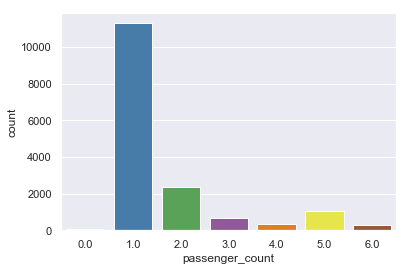

In [174]:
sns.countplot(x='passenger_count' ,data=train)

In [150]:
drop=['pickup_datetime','passenger_count','Year','Month','Date','Day of Week','Hour']

In [ ]:
pd.plotting.scatter_matrix(train.drop(drop,axis=1), figsize = [8, 8])

-  Now lets see at some Jointplots.
-  They are used for Bivariate Analysis.
-  Here Scatter plot has regression line between 2 variables along with separate Bar plots of both variables.
-  Also its annotated with pearson correlation coefficient and p value.

## Feature Engineering

#### 1.Feature Engineering for timestamp variable
-  we will derive new features from pickup_datetime variable
-  new features will be year,month,date,day_of_week,hour

In [134]:
# we will Join 2 Dataframes pickup_datetime and train
train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [135]:
train.shape

(15661, 7)

In [136]:
train=train.reset_index(drop=True)

As we discussed in Missing value imputation step about dropping missing value, we will do it now.

In [137]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [138]:
train=train.dropna()

In [139]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [140]:
train_nodummies=train.copy()
# train=train_nodummies.copy()

In [141]:
def f(x):
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night (PM)'
    elif (x >=0) and (x <=4):
        return'night (AM)'

In [142]:
def g(x):
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [143]:
def h(x):
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [144]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)
# train_nodummies['session'] = train_nodummies['hour'].apply(f)

In [145]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)
# train['seasons'] = test['month'].apply(g)

In [146]:
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [147]:
train.shape

(15660, 14)

In [148]:
test.shape

(9914, 13)

#### 2.Feature Engineering for passenger_count variable
- Because models in scikit learn require numerical input,if dataset contains categorical variables then we have to encode them.
- We will use one hot encoding technique for passenger_count variable.

In [149]:
train['passenger_count'].describe()

count     15660
unique        6
top           1
freq      11031
Name: passenger_count, dtype: int64

In [150]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [153]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night (AM),session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [154]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night (AM),session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


#### 3.Feature Engineering for latitude and longitude variable
-  As we have latitude and longitude data for pickup and dropoff, we will find the distance the cab travelled from pickup and dropoff location.

In [ ]:
# train.sort_values('pickup_datetime')

In [36]:
# def haversine(coord1, coord2):
#     '''Calculate distance the cab travelled from pickup and dropoff location using the Haversine Formula'''
#     data = [train, test]
#     for i in data:
#         lon1, lat1 = coord1
#         lon2, lat2 = coord2
#         R = 6371000  # radius of Earth in meters
#         phi_1 = np.radians(i[lat1])
#         phi_2 = np.radians(i[lat2])
#         delta_phi = np.radians(i[lat2] - i[lat1])
#         delta_lambda = np.radians(i[lon2] - i[lon1])
#         a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         meters = R * c  # output distance in meters
#         km = meters / 1000.0  # output distance in kilometers
#         miles = round(km, 3)/1.609344
#         i['distance'] = miles
# #     print(f"Distance: {miles} miles")
# #     return miles

In [37]:
# haversine(['pickup_longitude','pickup_latitude'],['dropoff_longitude','dropoff_latitude'])

https://pypi.org/project/geopy/

https://www.quora.com/What-is-the-best-way-to-treat-longitude-latitude-features-in-a-machine-learning-predictive-model

https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula

https://geopy.readthedocs.io/en/latest/#module-geopy.distance

https://stackoverflow.com/questions/38248046/is-the-haversine-formula-or-the-vincentys-formula-better-for-calculating-distan

In [162]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test,train_nodummies]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [156]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,1,0,0,0,0,0,0,0.640488,0.639764
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,0,0,1,0,0,0,0,0.863412,0.863167
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,0,0,0,1,0,0,0,1.739388,1.737223
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.241710


In [157]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.442197
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.506080
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384120
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,1,0,0,0,1,0,0,0,1.218531,1.217683
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,1,0,0,0,1,0,0,0,3.347519,3.344737


As Vincenty is more accurate than haversine. Also vincenty is prefered for short distances.Therefore we will drop distance and great_circle. we will drop them together with other variables which were used to feature engineer.

As we discussed in Missing value imputation step about dropping missing value, we will do it now.

In [158]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0


In [159]:
pd.DataFrame(train_nodummies.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0


#### We will remove the variables which were used to feature engineer new variables

In [164]:
train_nodummies=train_nodummies.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','great_circle'],axis = 1)
test_nodummies=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night (AM)', 'session_night (PM)',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'great_circle'],axis = 1)

In [166]:
train_nodummies.shape,test_nodummies.shape

((15660, 7), (9914, 9))

In [165]:
train=train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)

In [167]:
train.shape,test.shape

((15660, 26), (9914, 25))

In [70]:
# train = train.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','great_circle','passenger_count','year',
#        'month', 'day_of_week', 'hour', 'session', 'seasons', 'week'],axis = 1)
# test = test.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','great_circle','passenger_count','year',
#        'month', 'day_of_week', 'hour', 'session', 'seasons', 'week'],axis = 1)
# # train = train.drop(['pickup_datetime'],axis = 1),'passenger_count'

In [168]:
test_nodummies.columns

Index(['passenger_count', 'year', 'month', 'day_of_week', 'hour', 'session',
       'seasons', 'week', 'geodesic'],
      dtype='object')

In [169]:
train_nodummies.columns

Index(['fare_amount', 'passenger_count', 'year', 'month', 'day_of_week',
       'hour', 'geodesic'],
      dtype='object')

In [170]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night (AM)',
       'session_night (PM)', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [171]:
test.columns

Index(['passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night (AM)', 'session_night (PM)',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [172]:
train.head()

,fare_amount,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_fall,season_spring,season_summer,...,session_night (AM),session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0.639764
1,16.9,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5.246511
2,5.7,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0.863167
3,7.7,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1.737223
4,5.3,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1.241710


In [173]:
test.head()

,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_fall,season_spring,season_summer,season_winter,...,session_night (AM),session_night (PM),year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.442197
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.506080
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.384120
3,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1.217683
4,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,3.344737


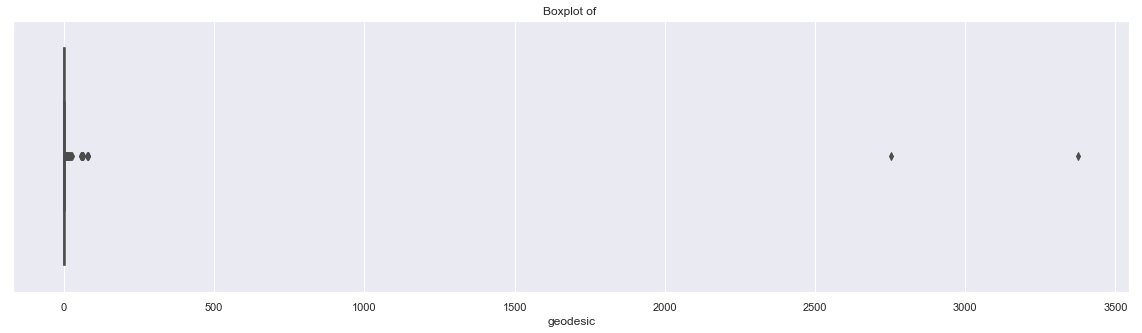

In [30]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of ')
#     plt.savefig('bp'+str(i)+'.png')
plt.show()

In [174]:
outlier_treatment('geodesic')

2.425668049965582 0.7815214474966259
-1.6846984562068081 4.891887953669016


In [177]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_1,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_fall,0
season_spring,0
season_summer,0


In [178]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 98.093
Imputing row 101/15660 with 0 missing, elapsed time: 99.041
Imputing row 201/15660 with 0 missing, elapsed time: 99.076
Imputing row 301/15660 with 1 missing, elapsed time: 99.083
Imputing row 401/15660 with 0 missing, elapsed time: 99.089
Imputing row 501/15660 with 0 missing, elapsed time: 99.093
Imputing row 601/15660 with 1 missing, elapsed time: 99.095
Imputing row 701/15660 with 0 missing, elapsed time: 99.105
Imputing row 801/15660 with 0 missing, elapsed time: 99.122
Imputing row 901/15660 with 0 missing, elapsed time: 99.130
Imputing row 1001/15660 with 0 missing, elapsed time: 99.156
Imputing row 1101/15660 with 1 missing, elapsed time: 99.166
Imputing row 1201/15660 with 0 missing, elapsed time: 99.174
Imputing row 1301/15660 with 0 missing, elapsed time: 99.178
Imputing row 1401/15660 with 0 missing, elapsed time: 99.182
Imputing row 1501/15660 with 0 missing, elapsed time: 99.186
Imputing row 1601/15660 with 0 missi

Imputing row 15201/15660 with 0 missing, elapsed time: 100.826
Imputing row 15301/15660 with 0 missing, elapsed time: 100.848
Imputing row 15401/15660 with 0 missing, elapsed time: 100.852
Imputing row 15501/15660 with 1 missing, elapsed time: 100.855
Imputing row 15601/15660 with 0 missing, elapsed time: 100.857


## Feature Selection
1.Correlation Analysis

    Statistically correlated: features move together directionally.
    Linear models assume feature independence.
    And if features are correlated that could introduce bias into our models.

In [52]:
# cat_var=['year','month','day_of_week','hour','passenger_count']
# num_var=['fare_amount','geodesic']
# train[cat_var]=train[cat_var].apply(lambda x: x.astype('category') )
# # test[cat_var]=test[cat_var].apply(lambda x: x.astype('category') )  ,'passenger_count'  'day_of_month'

-  We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.

In [ ]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix of all numerical variables')
# plt.savefig('correlation.png')
plt.show()

As we can see from above correlation plot fare_amount and geodesic is correlated to each other.

In [ ]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

## Analysis of Variance(Anova) Test
-  It is carried out to compare between each groups in a categorical variable.
-  ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
-  Hypothesis testing :
    -  Null Hypothesis: mean of all categories in a variable are same.
    -  Alternate Hypothesis: mean of at least one category in a variable is different.
-  If p-value is less than 0.05 then we reject the null hypothesis.
-  And if p-value is greater than 0.05 then we accept the null hypothesis.

In [ ]:
#ANOVA _1)+C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)
model = ols('fare_amount ~ C(year)+C(month)+C(day_of_month)+C(day_of_week)+C(hour)+C(passenger_count)',
                data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

## Multicollinearity Test
-  VIF is always greater or equal to 1.
-  if VIF is 1 --- Not correlated to any of the variables.
-  if VIF is between 1-5 --- Moderately correlated.
-  if VIF is above 5 --- Highly correlated.
-  If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [ ]:
# _1+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6
outcome, predictors = dmatrices('fare_amount ~ geodesic+year+month+day_of_month+day_of_week+hour+passenger_count',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

https://stats.stackexchange.com/questions/258325/is-number-of-children-categorical-data

https://statisticalhorizons.com/multicollinearity

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(train['year'])

plt.figure(figsize=(20,10))
sns.countplot(train['month'])

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_month'])

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])

In [ ]:
_ = sns.jointplot(x='fare_amount',y='geodesic',data=train,kind = 'reg')
# _.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

## Feature Scaling

In [46]:
train[num_var].var()

fare_amount    20.044364
geodesic        1.204608
dtype: float64

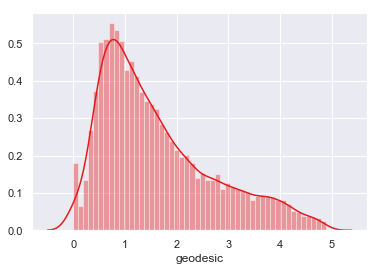

In [53]:
sns.distplot(train['geodesic'],bins=50)

((array([-3.92007182, -3.70085568, -3.58076887, ...,  3.58076887,
          3.70085568,  3.92007182]),
  array([0.        , 0.        , 0.        , ..., 4.88300333, 4.88468361,
         4.88875044])),
 (1.0513960924441437, 1.6213726643867186, 0.957753760202082))

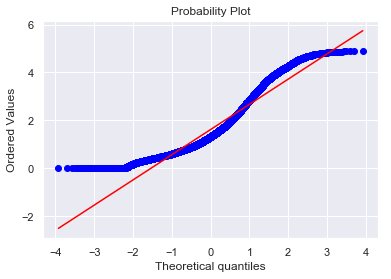

In [59]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)

In [79]:
#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [38]:
train['geodesic'].var()

0.05040223902022794

In [ ]:
train.head()

## Splitting train into train and validation subsets
- X_train y_train--are train subset
- X_test y_test--are validation subset

In [181]:
X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15660, 26) (11745, 25) (3915, 25) (11745,) (3915,)


In [182]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

## Multiple Linear Regression

R^2: 0.7378200382396708
Root Mean Squared Error: 2.318998828890487
<<<------------------- Training Data Score --------------------->

r square   0.7321789685906825
Adjusted r square:0.731607629245582
MAPE:18.78844242554429
MSE: 5.328887425524238
RMSE: 2.3084383087975815
RMSLE: 0.21704402094088113

<<<------------------- Test Data Score --------------------->

r square   0.7378200382396708
Adjusted r square:0.7361346437824817
MAPE:19.028764046558386
MSE: 5.37775556839545
RMSE: 2.318998828890487
RMSLE: 0.2164160779763651
[-5.94335385e+12 -5.94335385e+12 -5.94335385e+12 -5.94335385e+12
 -5.94335385e+12 -5.94335385e+12 -2.19644568e+12 -2.19644568e+12
 -2.19644568e+12 -2.19644568e+12 -4.52401842e+11 -4.52401842e+11
  8.06519748e+10  8.06519748e+10  8.06519748e+10  8.06519748e+10
  8.06519748e+10 -1.87757838e+11 -1.87757838e+11 -1.87757838e+11
 -1.87757838e+11 -1.87757838e+11 -1.87757838e+11 -1.87757838e+11
  3.42675489e+00]


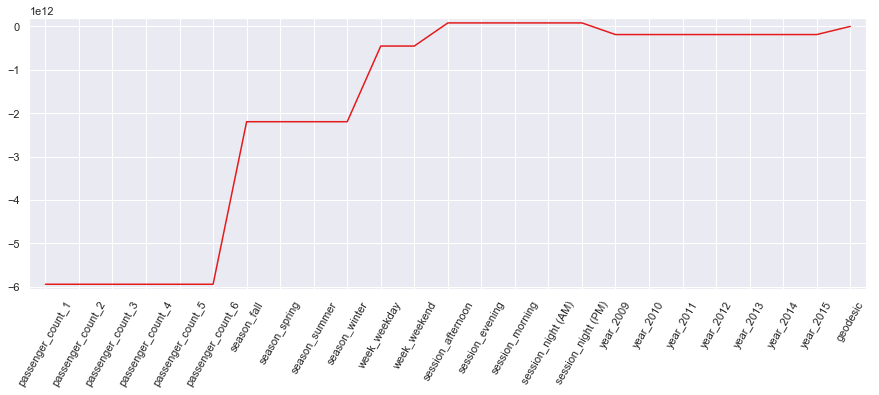

In [183]:
# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [184]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.36872646 -5.43659213 -5.15814597 -5.34848411 -5.46835335]
Average 5-Fold CV Score: -5.356060404274273


## Ridge Regression

In [185]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 1.0, 'max_iter': 500, 'normalize': False}
Best score is 0.7327522045699818


[-0.13454059 -0.11020435  0.01149503  0.07221609  0.09202378  0.06901005
  0.34130016 -0.10535009 -0.10564188 -0.13030819  0.10525864 -0.10525864
  0.48172594  0.06767513  0.00383345 -0.22102857 -0.33220594 -0.71467651
 -0.75773244 -0.6943055  -0.25894643  0.58461994  0.79845772  1.04258322
  3.42774057]


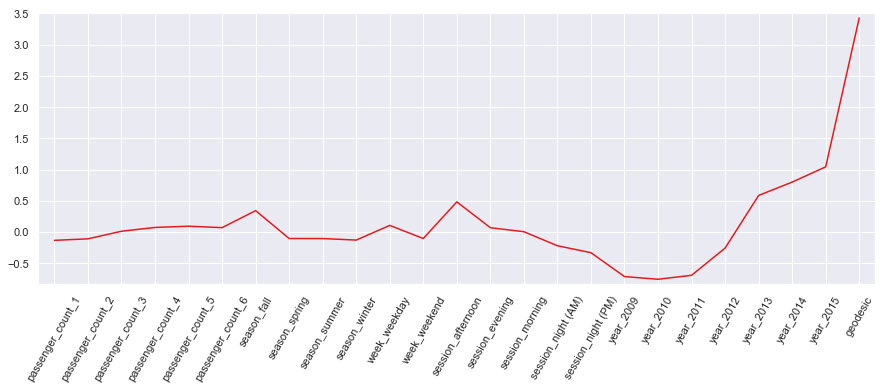

<<<------------------- Training Data Score --------------------->

r square   0.7321887258593661
Adjusted r square:0.731617407329328
MAPE:18.787889470528324
MSE: 5.32869328324153
RMSE: 2.308396257846891
RMSLE: 0.21703939810928527

<<<------------------- Test Data Score --------------------->

r square   0.7376932024024752
Adjusted r square:0.7360069925953427
MAPE:19.027353249133103
MSE: 5.380357186479348
RMSE: 2.3195596966836933
RMSLE: 0.2164487152317447


In [186]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=1, normalize=False,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), ridge_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

lasso can be used feature selection

## Lasso Regression

In [187]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.0011513953993264468, 'max_iter': 500, 'normalize': False}
Best score is 0.7327912552574969


[-9.29960381e-02 -7.99872542e-02  0.00000000e+00  0.00000000e+00
  4.19610942e-03  0.00000000e+00  3.93128498e-01  1.28543993e-02
 -0.00000000e+00 -2.45754595e-02  1.86601747e-01 -2.21303310e-17
  4.76250614e-01  1.09037285e-01 -0.00000000e+00 -2.10744270e-01
 -2.81304895e-01 -4.85021009e-01 -5.01695176e-01 -4.80204162e-01
 -0.00000000e+00  8.34009912e-01  1.01991095e+00  1.27984913e+00
  3.42140894e+00]
<<<------------------- Training Data Score --------------------->

r square   0.7320351133578924
Adjusted r square:0.7314634671281754
MAPE:18.813034221941475
MSE: 5.331749741217213
RMSE: 2.309058193553643
RMSLE: 0.21694431567112893

<<<------------------- Test Data Score --------------------->

r square   0.7386011955762682
Adjusted r square:0.7369208227013406
MAPE:19.028093076839095
MSE: 5.36173270689042
RMSE: 2.315541558014112
RMSLE: 0.21599700589920182


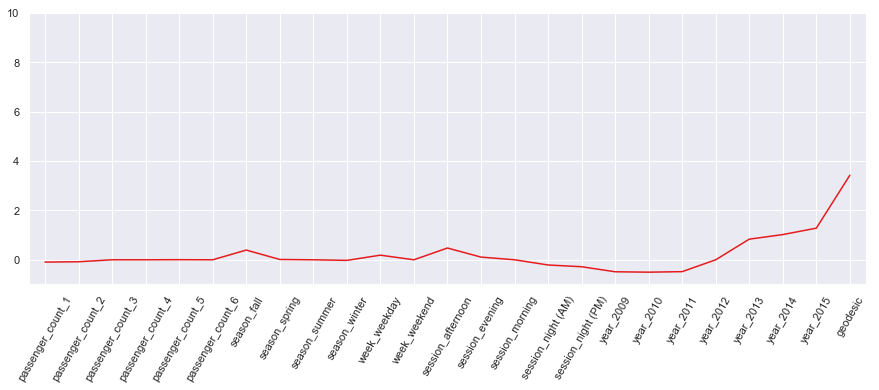

In [188]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.0011513953993264468, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.ylim(-1,10)
plt.plot(range(len(test.columns)), lasso_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.show()
test_scores(lasso)

## Decision Tree Regression

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 7 columns):
fare_amount        15660 non-null float64
passenger_count    15660 non-null category
year               15660 non-null category
month              15660 non-null category
day_of_week        15660 non-null category
hour               15660 non-null category
geodesic           15660 non-null float64
dtypes: category(5), float64(2)
memory usage: 445.7 KB


In [189]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 4}
Best score is 0.7292420090626064


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.49681421e-04 0.00000000e+00
 3.18185273e-03 4.38646260e-04 0.00000000e+00 0.00000000e+00
 4.24073610e-04 4.34427597e-04 1.19778244e-03 7.15586511e-04
 8.58921346e-04 1.09975438e-02 1.08340054e-02 9.40740727e-03
 9.61260072e-01]


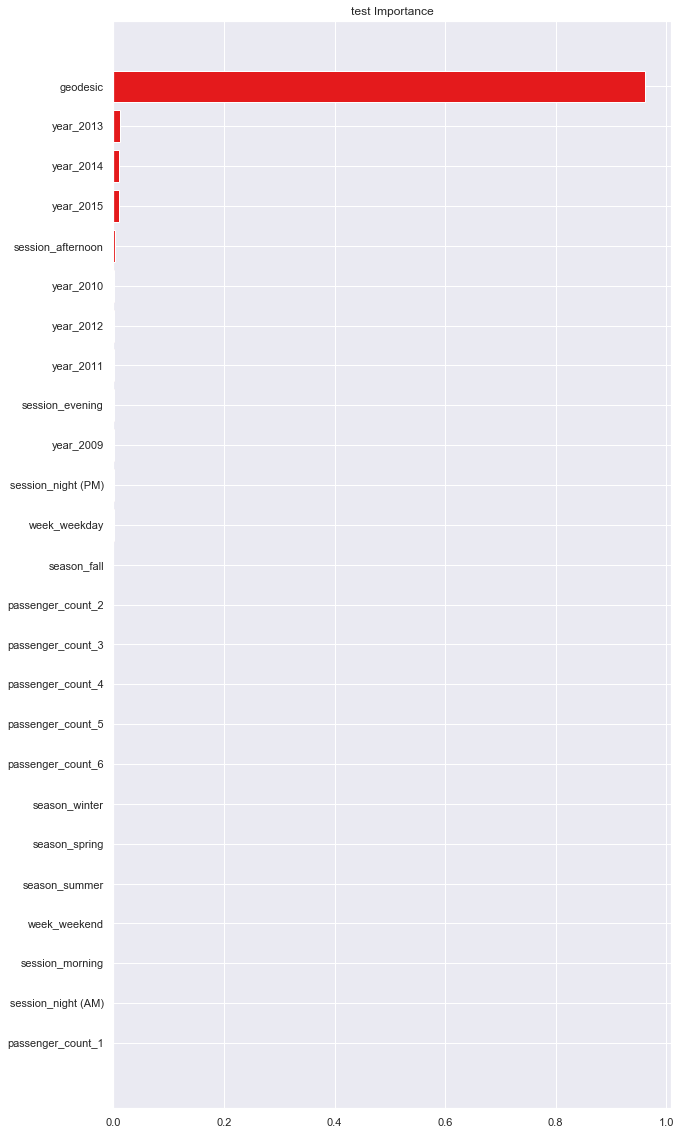

<<<------------------- Training Data Score --------------------->

r square   0.74623665109475
Adjusted r square:0.7456953008325578
MAPE:18.565724594287612
MSE: 5.049178968224455
RMSE: 2.2470378208264443
RMSLE: 0.20899413300081476

<<<------------------- Test Data Score --------------------->

r square   0.734776485281142
Adjusted r square:0.7330715256853664
MAPE:19.213397854090605
MSE: 5.44018400022731
RMSE: 2.3324202023278975
RMSLE: 0.21341635519884006


In [192]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=4)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(10,20))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Random Forest Regression

In [198]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Decision Forest Parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
Best score is 0.7377590235294056


[0.00508712 0.00444412 0.0026545  0.00177297 0.00331107 0.00144427
 0.00602809 0.00485525 0.00504671 0.00471332 0.00492308 0.00486498
 0.00572068 0.00439002 0.00452647 0.00686708 0.00477025 0.0045233
 0.00601411 0.00401808 0.00375239 0.00750796 0.00812026 0.00640833
 0.8842356 ]


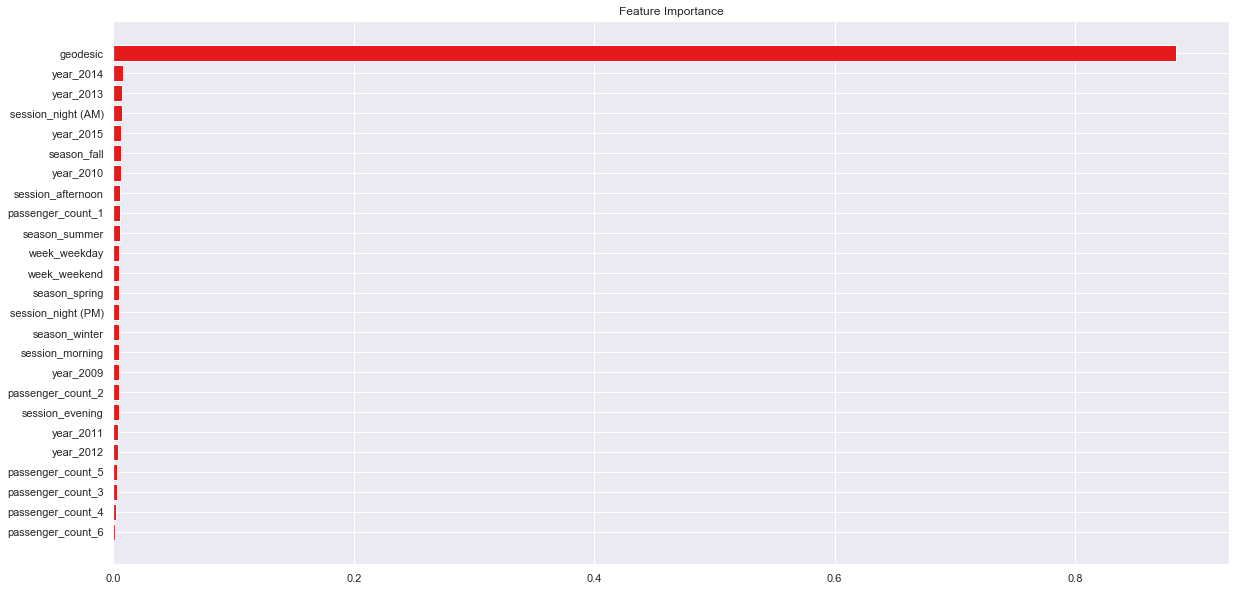

<<<------------------- Training Data Score --------------------->

r square   0.8292716594364724
Adjusted r square:0.8289074467464743
MAPE:16.24538274939807
MSE: 3.3970151724908577
RMSE: 1.8430993387473333
RMSLE: 0.17736831107188422

<<<------------------- Test Data Score --------------------->

r square   0.7438589444777233
Adjusted r square:0.7422123704514808
MAPE:19.99632628031775
MSE: 5.253887361875563
RMSE: 2.292135982413688
RMSLE: 0.21596193290672205


In [199]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 4, min_samples_leaf=2, max_features='sqrt', max_depth=14, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

## Improving accuracy using XGBOOST
Improve Accuracy a) Algorithm Tuning b) Ensembles
Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

In [193]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(xgb)

ModuleNotFoundError: No module named 'xgboost'

In [179]:
test.columns

Index(['passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night (AM)', 'session_night (PM)',
       'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [180]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night (AM)',
       'session_night (PM)', 'year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

https://www.kaggle.com/dhrubajitdas/model-comparison-accuracyscore-rmse

https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/model-assumptions/validate-model-assumptions/